# Model Training
--- 

## Zillow CA Rent Model
---

In [154]:
import logging

# Create a logger
logger = logging.getLogger(__name__)
# Set the logging level
logger.setLevel(logging.INFO)
# Create a file handler which logs even debug messages
file_handler = logging.FileHandler('training.log')
file_handler.setLevel(logging.INFO)
# Create a formatter and set the formatter for the file handler
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
# Add the handlers to the logger
logger.addHandler(file_handler)
# Log a message to ensure the logger is working
logger.info('Training logger initialized')


### Load Training Data
---

In [155]:
import pandas as pd

TRAINING_DATA_ROOT_DIR='../data/training_data/'
ca_rent_training_set_1 = pd.read_feather(f'{TRAINING_DATA_ROOT_DIR}ca_rent_training_data_1.ft')

## Model Training
---

In [156]:

from sklearn.linear_model import LinearRegression

def train_linear_regression(X_train, y_train):
    """
    Trains a linear regression model on the given training data.

    Parameters:
    X_train (DataFrame): Training features.
    y_train (Series): Training target.

    Returns:
    LinearRegression: The trained linear regression model.
    """
    # Initialize the linear regression model
    model = LinearRegression()
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Log the model training completion
    logger.info('Linear regression model training completed')
    
    # Return the trained model
    return model


In [157]:
from sklearn.model_selection import GridSearchCV

def find_optimal_parameters(X, y, model):
    """
    Finds the optimal parameters for a given linear regression model using GridSearchCV.

    Parameters:
    X (DataFrame): Features.
    y (Series): Target.
    model (LinearRegression): The linear regression model instance.

    Returns:
    dict: A dictionary containing the optimal parameters.
    """
    # Define the parameters to search
    param_grid = {
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'copy_X': [True, False]
    }
    
    # Initialize the GridSearchCV with the model and parameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    
    # Fit the GridSearchCV to the data
    grid_search.fit(X, y)
    
    # Return the optimal parameters
    return grid_search.best_params_

In [158]:
from sklearn.ensemble import VotingRegressor

def create_ensembled_model(models, X_train, y_train):
    """
    Creates an ensembled model from a given set of models using VotingRegressor.

    Parameters:
    models (list): List of tuples where each tuple contains a model name and the model instance.
    X_train (DataFrame): Training features.
    y_train (Series): Training target.

    Returns:
    VotingRegressor: An ensembled model.
    """
    ensembled_model = VotingRegressor(estimators=models)
    ensembled_model.fit(X_train, y_train)
    return ensembled_model

#### Model 1
----


## Preparing training data for model training
---
- encode all categorical data
- normalize data


In [159]:
from dataclasses import dataclass

@dataclass
@dataclass
class Model:
    model_name: str
    model_metrics: dict
    model: object

# Example usage:
#model1 = Model("Linear Regression", {"RMSE": 0.5, "R2": 0.8}, LinearRegression())
#print(model1.model_name)  # Output: Linear Regression
#print(model1.model_metrics)  # Output: {"RMSE": 0.5, "R2": 0.8}
#print(model1.model)  # Output: LinearRegression object


In [160]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def preprocess_data(df):
    """
    Encodes all categorical data and normalizes the data.

    Parameters:
    df (DataFrame): DataFrame to preprocess.

    Returns:
    DataFrame: Preprocessed DataFrame.
    """
    # Initialize encoder and scaler
    encoder = OneHotEncoder(sparse=False)
    scaler = StandardScaler()

    # Fit and transform categorical data
    encoded_data = encoder.fit_transform(df.select_dtypes(include=['object']))

    # Drop original categorical columns
    df = df.drop(columns=df.select_dtypes(include=['object']).columns)

    # Add encoded data to the DataFrame
    df = df.join(pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out()))

    # Scale numerical data
    scaled_data = scaler.fit_transform(df.select_dtypes(include=['int64', 'float64']))

    # Replace original numerical columns with scaled data
    df = pd.DataFrame(scaled_data, columns=df.select_dtypes(include=['int64', 'float64']).columns)

    return df

In [161]:
prepped_ca_rent_training_data_1 = preprocess_data(ca_rent_training_set_1)

/Users/oscarlopez/Desktop/portfolio/Zillow_Housing_Predictor/env/zillow_project/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Training Linear Regression Models
---

In [162]:
import matplotlib.pyplot as plt
def display_model_metrics_as_bar(model, X_test, y_test):
    """
    Displays the metrics of a model as a bar graph, including MSE, R2, MAE, and Accuracy.
    
    Parameters:
    - model: The model to evaluate.
    - X_test: The test features.
    - y_test: The test target.
    """
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # Check if y_test is binary for accuracy calculation
    if y_test.nunique() == 2:  # Assuming binary classification if y_test has only two unique values
        accuracy = accuracy_score(y_test, y_pred > 0.5)  # Assuming binary classification with threshold 0.5
    else:
        accuracy = None  # Set accuracy to None if y_test is not binary
    
    # Plotting
    plt.figure(figsize=(15, 5))  # Adjusted figure size to accommodate four metrics
    metrics_to_plot = ['MSE', 'R2', 'MAE']
    values_to_plot = [mse, r2, mae]
    if accuracy is not None:
        metrics_to_plot.append('Accuracy')
        values_to_plot.append(accuracy)
    plt.bar(metrics_to_plot, values_to_plot)
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title(f'Model Metrics: MSE={mse:.2f}, R2={r2:.2f}, MAE={mae:.2f}, Accuracy={accuracy:.2f}' if accuracy is not None else f'Model Metrics: MSE={mse:.2f}, R2={r2:.2f}, MAE={mae:.2f}')
    plt.grid(True)
    plt.show()

In [163]:
X_train = prepped_ca_rent_training_data_1.drop('rent', axis=1)
y_train = prepped_ca_rent_training_data_1['rent']



lr_ca_rent_model_1 = train_linear_regression(X_train,y_train)


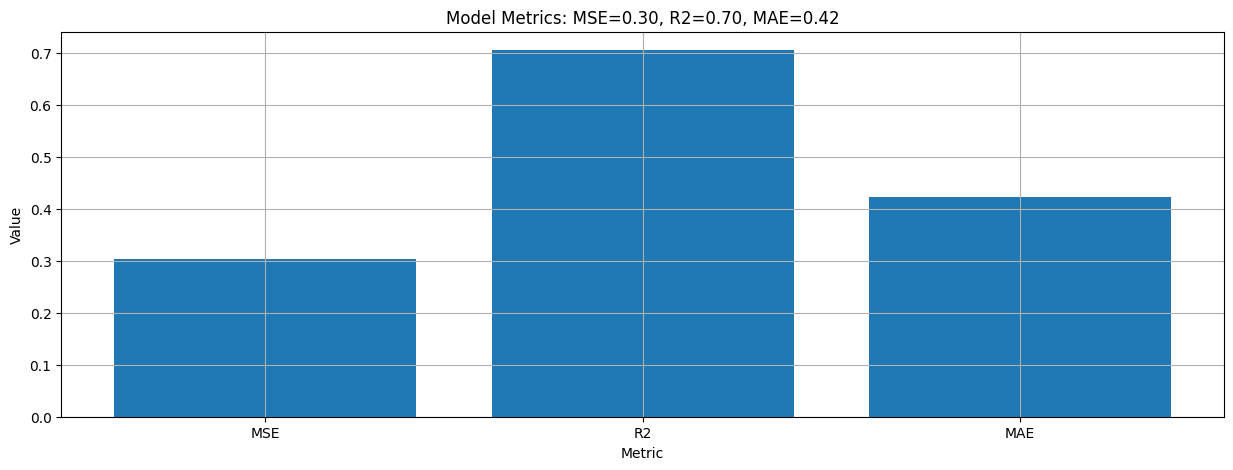

In [164]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

display_model_metrics_as_bar(lr_ca_rent_model_1,X_test,y_test)

## Testing Regression Models
---

In [165]:
def test_regression_model(model, X_test, y_test):
    """
    Tests a given regression model on the provided test data and returns a dictionary containing relevant metrics, including Mean Squared Error (MSE), R-Squared (R2), Mean Absolute Error (MAE), and a custom accuracy metric.
    
    Parameters:
    - model: The regression model to be tested.
    - X_test: The test data features.
    - y_test: The test data target variable.
    
    Returns:
    - A dictionary containing the model's metrics, including Mean Squared Error (MSE), R-Squared (R2), Mean Absolute Error (MAE), and a custom accuracy metric.
    """
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics calculation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Return metrics as a dictionary
    return {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
    }

### Model 1 Metrics.
---

In [166]:
# Will be saving model as a dataclass object.
lr_ca_rent_model_1_metrics = test_regression_model(lr_ca_rent_model_1, X_test, y_test)
print(lr_ca_rent_model_1_metrics)
model_1 = Model(model_name='CA_Rental_Linear_Regression_Model_1', model = lr_ca_rent_model_1, model_metrics=lr_ca_rent_model_1_metrics)



{'MSE': 0.30406086617963124, 'R2': 0.704835429491867, 'MAE': 0.42314376265998965}


In [167]:
import pickle
import json
import os

def save_model(model: Model, root_directory: str):
    """
    Saves a model dataclass object to a directory named after the model within a specified root directory and saves its metrics as a JSON file within the same directory.

    Parameters:
    - model: The model dataclass object to be saved.
    - root_directory: The root directory where the model directory will be created.
    """
    # Construct the directory path for the model
    model_directory = f"{root_directory}/{model.model_name}"
    
    # Ensure the directory exists
    os.makedirs(model_directory, exist_ok=True)
    
    # Construct the file path for the model
    model_file_path = f"{model_directory}/{model.model_name}.pkl"
    
    # Open the file in binary write mode
    with open(model_file_path, 'wb') as file:
        # Use pickle to serialize and save the model
        pickle.dump(model, file)
    
    # Construct the file path for the metrics
    metrics_file_path = f"{model_directory}/{model.model_name}_metrics.json"
    
    # Open the file in write mode
    with open(metrics_file_path, 'w') as file:
        # Use json to serialize and save the metrics
        json.dump(model.model_metrics, file)
    
    print(f"Model saved to {model_file_path} and metrics saved to {metrics_file_path}")


## Optimizing Models
---


In [168]:
from sklearn.model_selection import GridSearchCV

def find_optimal_parameters(X, y, model):
    """
    Finds the optimal parameters for a given linear regression model using GridSearchCV.

    Parameters:
    X (DataFrame): Features.
    y (Series): Target.
    model (LinearRegression): The linear regression model instance.

    Returns:
    dict: A dictionary containing the optimal parameters.
    """
    # Define the parameters to search
    param_grid = {
        'fit_intercept': [True, False],
        'positive': [True, False],
        'copy_X': [True, False]
    }
    
    # Initialize the GridSearchCV with the model and parameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    # Ensure X and y have consistent sample sizes
    if len(X) != len(y):
        raise ValueError("X and y must have the same number of samples.")
    
    # Fit the GridSearchCV to the data using all available CPU cores for faster processing
    grid_search.fit(X, y)
    
    # Return the optimal parameters
    return grid_search.best_params_

In [169]:
def optimize_regression_model(model, X_train, y_train):
    optimal_parameters = find_optimal_parameters(X_train, y_train, model)
    model.set_params(**optimal_parameters)
    return model


In [170]:
optimized_model_1 = optimize_regression_model(X_train=X_train,y_train=y_train,model = model_1.model)

In [171]:

optimized_regression_model_1_metrics = test_regression_model(optimized_model_1, X_test, y_test)


In [172]:
optimized_regression_model_1 = Model(model_name='Optimized CA Rent Linear Regression Model 1', model_metrics=optimized_regression_model_1_metrics,model=optimized_model_1)

In [173]:
MODEL_ROOT_DIR = '../models/'

save_model(optimized_regression_model_1,MODEL_ROOT_DIR)


NameError: name 'os' is not defined